In [38]:
# growthrates
import numpy as np
import pandas as pd
import string
import os
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.optimize import curve_fit

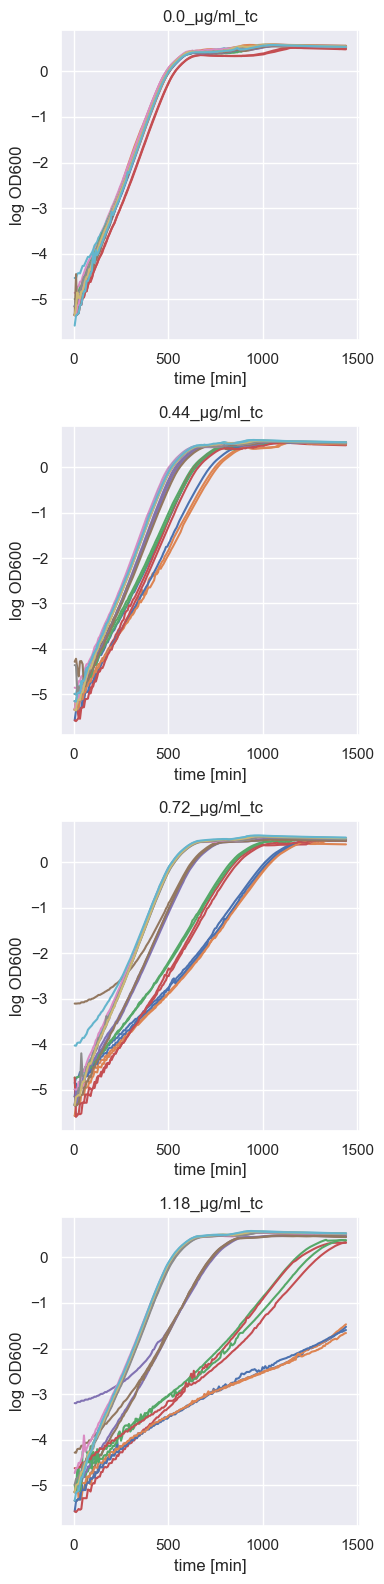

In [36]:
def transform_time(time):
    hours = int(time.split(':')[0])
    minutes = int(time.split(':')[1])
    seconds = int(time.split(':')[2])

    return hours * 60 + minutes + seconds / 60

def format_data(experiment):
    # get info from file name
    date = experiment.split('_')[0]
    run = experiment.split('_')[1][1]
    plate = experiment.split('_')[2][-1]

    # get path to layout file
    layout_file = '../../data/plate_reader/' + experiment + f'/{date}_plate_layout.xlsx'

    # import layout file
    xl = pd.ExcelFile(layout_file)
    

    # extract layout
    layout = xl.sheet_names
    layout_info=list()
    for l in layout:
        info = pd.read_excel(layout_file, sheet_name=l, header=None).values
        info = info.ravel()
        layout_info.append(info)

    # read data
    data = pd.read_csv('../../data/plate_reader/' + experiment + f'/{experiment}.txt', header=None)

    # put data into tidy dataframe with metadata
    columns=['time_min', 'temp_C', 'OD600'] + layout
    df = pd.DataFrame(columns=columns)
    
    for i, col in enumerate(data.loc[:,2:].columns):
        df_well = pd.DataFrame(columns=columns)
        df_well['time_min'] = data.loc[:, 0].apply(transform_time)
        df_well['temp_C'] = data.loc[:, 1]
        df_well['OD600'] = data[col]
        for l, param in enumerate(layout):
            df_well[param] = layout_info[l][i]
            
        df = pd.concat([df, df_well])

    # subtract blank OD
    blank_mean = df.loc[df['strain'] == "blank", :].groupby('time_min')['OD600'].apply(np.mean).reset_index()

    df['OD600_norm'] = 0
    for time in np.unique(df['time_min'].values):
        df.loc[df['time_min'] == time,'OD600_norm'] = df.loc[df['time_min'] == time,'OD600'] - blank_mean.loc[blank_mean['time_min'] == time, 'OD600'].values[0]
        df = df.loc[df['strain'] != 'blank', :]
        df = df.loc[df['strain'] != 'n', :]

    # compute log OD
    df['log_OD600']=np.log(df['OD600_norm'])

    # Look at the growth curves per concentration
    concentrations = df['pos_selection'].unique()
    
    fig, ax = plt.subplots(len(concentrations), 1, figsize=(4, 4*len(concentrations)))
    for i, c in enumerate(df['pos_selection'].unique()):
        _df = df.loc[df['pos_selection'] == c, :]
        ax[i].set_xlabel('time [min]')
        ax[i].set_ylabel('log OD600')
        ax[i].set_title(c)
        for well in _df['well'].unique():
            ax[i].plot(_df.loc[_df['well'] == well, 'time_min'], _df.loc[_df['well'] == well, 'log_OD600'])

    fig.tight_layout()
    return df

df = format_data('20230509_r2_plate2')

In [42]:
def get_growth_rates(df, low, high):
    # filter for time values
    _df = df[(low < df['time_min']) &(df['time_min'] < high)]

    def test_func(x,A,B):
        return A*x+B
    # create dataframe to store output
    df_out = pd.DataFrame()

    # iterate through wells and get growth rate
    for i, well in enumerate(_df['well'].unique()):
        parameters, variance = curve_fit(test_func, _df.loc[_df['well'] == well, 'time_min'], _df.loc[_df['well'] == well, 'log_OD600'])
        slope = parameters [0]
        df_out = pd.concat([df_out, pd.DataFrame(data={'well': [well], 'slope': [slope]})])
        
    return df_out

get_growth_rates(df, 250, 500)

,well,slope
0,A02,0.011053
0,A03,0.010483
0,A04,0.010752
0,A05,0.011073
0,A06,0.011003
...,...,...
0,H07,0.006591
0,H08,0.010196
0,H09,0.010395
0,H10,0.010516
